In [10]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

plt.rcParams.update({
    #"text.usetex": True,
    "font.size": 14,      
    "axes.titlesize": 14,  
    "axes.labelsize": 14, 
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14})

In [21]:
results_dir = Path('Results/MLPTrainingAndTesting')
results_dir.mkdir(exist_ok=True)

plots_dir = Path('Plots/MLPTrainingAndTesting')
plots_dir.mkdir(exist_ok=True)

In [2]:
def process_data(n):
# Import Data and convert to tensor
    binary = True

    X = np.load("Datasets/kryptonite-%s-X.npy"%(n))
    y = np.load("Datasets/kryptonite-%s-y.npy"%(n))
    if binary:
        X = np.where(X>0.5, 1, 0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  # 20% test

    X_train = torch.tensor(X_train.astype(np.float32)).to(device)
    y_train = torch.tensor(y_train.astype(np.float32)).unsqueeze(1).to(device)

    X_test = torch.tensor(X_test.astype(np.float32)).to(device)
    y_test = torch.tensor(y_test.astype(np.float32)).unsqueeze(1).to(device)

    return X_train, y_train, X_test, y_test

In [3]:
# Define Model

class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def training(para, n):
    # Store training accuracy for each run and each epoch
    train_acc_list={0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
    train_loss_list={0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
    # Test accuracy for each run
    test_acc_list = []

    for count in range(10):

        X_train, y_train, X_test, y_test = process_data(n)

        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=para["batch_size"][0], shuffle=True)

        model = NeuralNet(n, para["hidden_size"][0]).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=para["lr"][0], weight_decay=para["alpha"][0])

        num_epochs = para["num_epochs"][0]
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0 # accuracy calculator
            for input, label in train_loader:
                optimizer.zero_grad()
                outputs = model(input)
                loss = criterion(outputs, label)
                loss.backward()
                optimizer.step()
                
                correct += (outputs.round()==label).float().sum().item()
                running_loss+=loss.item()

            avg_loss = running_loss/len(train_loader)
            accuracy = 100*correct/len(X_train)
            train_loss_list[count].append(avg_loss)
            train_acc_list[count].append(accuracy)

        model.eval()
        test_loss = 0.0
        correct = 0
        test_dataset = TensorDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, shuffle=False)

        for input, label in test_loader:
            target = model(input)
            loss = criterion(target, label)
            correct += (target.round()==label).float().sum().item()
        accuracy = 100*correct/len(X_test)
        if count==0:
            best_model=model
        else:
            if accuracy>test_acc_list[-1]:
                best_model=model
        test_acc_list.append(accuracy)
            
    return train_acc_list, np.array(test_acc_list), best_model


In [5]:
def mean_acc(train_acc_list):

    # Calculate Mean and std for each epoch across runs
    train_acc = []

    for i in range(len(train_acc_list)):
        train_acc.append(train_acc_list[i])

    train_acc = np.array(train_acc)   
    train_mean = np.mean(train_acc, axis=0)   
    train_std = np.std(train_acc, axis=0)

    return train_mean, train_std

In [11]:
csv_file = results_dir / "mlp_training_results.csv"

In [19]:
# Mean and std for different n
train_mean = []
train_std = []
test_mean = []
test_std = []
dataset_size = [9,12,15]

# Write headers to the CSV file
with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["n", "run", "test_acc", "train_acc"])

for n in dataset_size:
    para = {"hidden_size":[4*n], "lr":[0.01], "alpha":[0.0001], "batch_size":[128], "num_epochs":[100]}
    train_acc_list, test_acc_list, best_model = training(para, n)
    
    #torch.save(best_model.state_dict(), 'model/'+str(n)+'model_best.pth')

    a,b = mean_acc(train_acc_list)
    train_mean.append(a)
    train_std.append(b)
    test_mean.append(np.mean(test_acc_list))
    test_std.append(np.std(test_acc_list))
    
    # Save results for each run into the CSV file
    with open(csv_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        for run, test_acc in enumerate(test_acc_list):
            train_acc = train_acc_list[run][-1]
            writer.writerow([n, run, test_acc, train_acc])

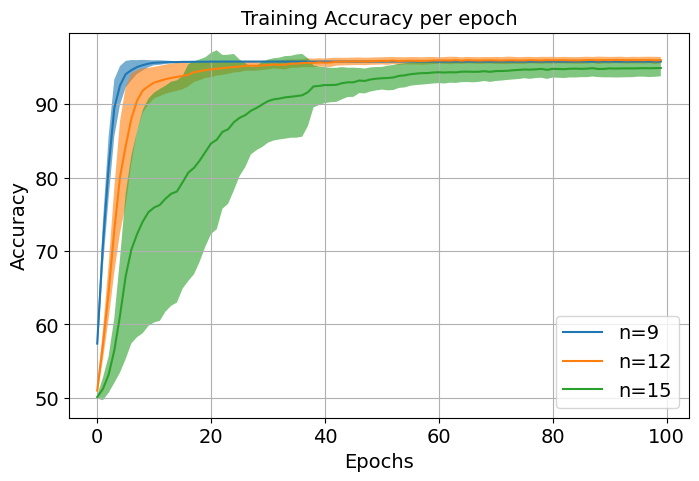

In [22]:
plt.figure(figsize=(8,5))
for i in range(len(dataset_size)):
    plt.plot(train_mean[i], label="n="+str(dataset_size[i]))
    plt.fill_between(range(len(train_mean[i])),train_mean[i]-train_std[i],train_mean[i]+train_std[i],alpha=.6)
plt.legend()
plt.xlabel("Epochs" )
plt.ylabel("Accuracy")
plt.title("Training Accuracy per epoch")
plt.grid()
plt.savefig(plots_dir / "train_acc.pdf", bbox_inches='tight', format="pdf")

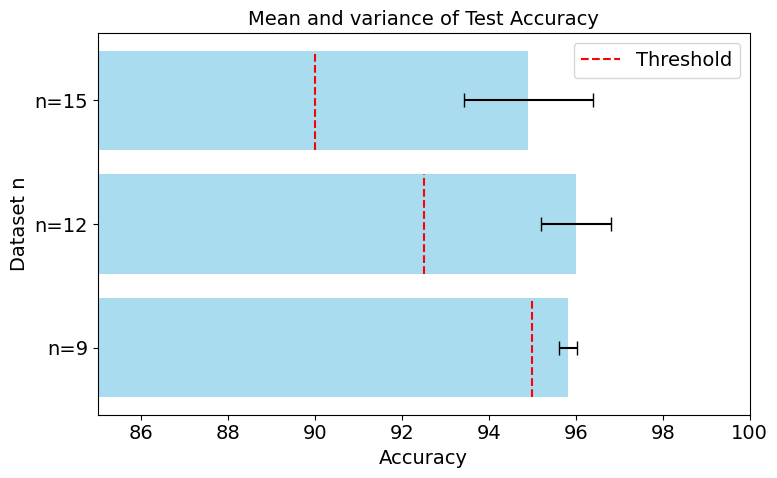

In [30]:
plt.figure(figsize=(8,5))

thresholds = [0.95, 0.925, 0.9]  # Threshold values

# Create the horizontal bar plot
y_labels = ["n=9", "n=12", "n=15"]
y_positions = range(len(y_labels))

plt.barh(y_labels, test_mean, xerr=test_std, capsize=5, color='skyblue', alpha=0.7)
plt.xlim((85, 100))  # Adjust x-axis range
plt.ylabel("Dataset n")
plt.xlabel("Accuracy")
plt.title("Mean and variance of Test Accuracy")

# Add individual vertical threshold lines (adjusted for horizontal orientation)
for i, threshold in enumerate(thresholds):
    plt.vlines(threshold * 100, i - 0.4, i + 0.4, colors='red', linestyles='dashed', label='Threshold' if i == 0 else "")

# Avoid overlapping elements
plt.legend(loc='best')
plt.tight_layout()

plt.savefig(plots_dir / "test_acc.pdf", bbox_inches='tight', format="pdf")

Generate hidden dataset labels

In [ ]:
for n in dataset_size:
    binary = True
    # Load the dataset
    X = np.load("Datasets/hidden-kryptonite-%s-X.npy"%(n))
    if binary:
        X = np.where(X>0.5, 1, 0)
    X = torch.tensor(X.astype(np.float32)).to(device)

    para = {"hidden_size":[4*n], "lr":[0.01], "alpha":[0.0001], "batch_size":[128], "num_epochs":[100]}
    model = NeuralNet(n, para["hidden_size"][0]).to(device)

    # Load the model
    model.load_state_dict(torch.load("model/%smodel_best.pth"%(n)))
    model.eval()

    output = model(X).cpu().detach().numpy()
    output = np.squeeze(output.round()).astype(np.int16)

    np.save('hiddenlabels/y_predicted_%s.npy'%(n), output)    

/tmp/ipykernel_462699/449237087.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/%smodel_best.pth"%(n)))
